In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import autograd.numpy as np
import pystan

from viabel import all_bounds
from viabel.approximations import MFStudentT, MultivariateT
from viabel.objectives import (black_box_klvi,
                               black_box_chivi)
from viabel.models import make_stan_log_density
from viabel.optimization import adagrad_optimize
from experiments import (get_samples_and_log_weights, 
                         improve_with_psis,
                         plot_history, 
                         plot_approx_and_exact_contours, 
                         plot_dist_to_opt_param,
                         check_approx_accuracy,
                         print_bounds)

sns.set_style('white')
sns.set_context('notebook', font_scale=2, rc={'lines.linewidth': 2})

In [2]:
os.makedirs('../figures', exist_ok=True)
lims = dict(xlim=[-4,-1], ylim=[-.5,3.5])
mc_samples = 1000000  # number of Monte Carlo samples for estimating bounds and for PSIS

# Robust Linear Regression Example

We will approximate the posterior for the simple 2D robust linear regression model
$$\beta_i \sim \mathcal{N}(0, 10)$$
$$y_n | x_n, \beta, \sigma \sim \mathcal{T}_{40}(\beta^\top x_n, 1)$$
and use Stan to compute (the gradient of) the model log density. 

For more details and discussion of this example, see:

[Practical posterior error bounds from variational objectives](https://arxiv.org/abs/1910.04102).
Jonathan H. Huggins,
Miko&#0322;aj Kasprzak,
Trevor Campbell,
Tamara Broderick.
In *Proc. of the 23rd International Conference on Artificial Intelligence and
Statistics* (AISTATS), Palermo, Italy. PMLR: Volume 108, 2020.

In [3]:
compiled_model_file = '../robust_reg_model.pkl'
try:
    with open(compiled_model_file, 'rb') as f:
        regression_model = pickle.load(f)
except:
    regression_model = pystan.StanModel(model_code=regression_model_code, model_name='regression_model')
    with open('robust_reg_model.pkl', 'wb') as f:
        pickle.dump(sm, f)

Generate 25 observations from the model with $\beta = (-2, 1)$:

In [4]:
np.random.seed(5039)
beta_gen = np.array([-2, 1])
N = 25
x = np.random.randn(N, 2).dot(np.array([[1,.75],[.75, 1]]))
y_raw = x.dot(beta_gen) + np.random.standard_t(40, N)
y = y_raw - np.mean(y_raw)

First, generate ground-truth posterior samples using Stan's dynamic HMC implementation:

In [5]:
data = dict(N=N, x=x, y=y, df=40)
fit = regression_model.sampling(data=data, iter=50000, thin=50, chains=10)

In [6]:
true_mean = np.mean(fit['beta'], axis=0)
true_cov = np.cov(fit['beta'].T)
print('true mean =', true_mean)
print('true cov =', true_cov)

true mean = [-2.51329837  1.50817005]
true cov = [[ 0.42597265 -0.42468946]
 [-0.42468946  0.4449887 ]]


In [7]:
fit

Inference for Stan model: regression_model_2f7d931ef1dc99d991576051801065c4.
10 chains, each with iter=50000; warmup=25000; thin=50; 
post-warmup draws per chain=500, total post-warmup draws=5000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]  -2.51  9.4e-3   0.65  -3.79  -2.96  -2.52  -2.09  -1.23   4855    1.0
beta[2]   1.51  9.6e-3   0.67   0.18   1.07   1.51   1.95   2.79   4864    1.0
lp__    -20.29    0.01   1.01 -23.03  -20.7 -19.98 -19.57 -19.31   4869    1.0

Samples were drawn using NUTS at Wed Nov  4 22:54:56 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

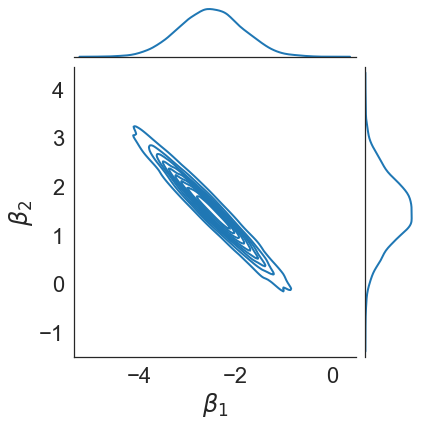

In [8]:
jp = sns.jointplot(x=fit['beta[1]'], y=fit['beta[2]'], kind='kde')
jp.set_axis_labels(r'$\beta_1$', r'$\beta_2$')
plt.show()

## Standard mean-field variational inference

Next, compute a mean field variational approximation using standard variational inference (that is, minimizing the KL-divergence):

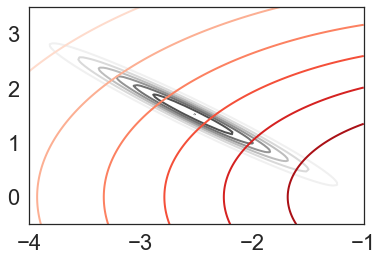

Average Loss = 24.21: 100%|██████████| 5000/5000 [00:24<00:00, 203.87it/s] 


In [9]:
mf_t_approx = MFStudentT(2, 40)
stan_log_density = make_stan_log_density(fit)
klvi_objective_and_grad = black_box_klvi(mf_t_approx, stan_log_density, 100)

init_mean    = np.zeros(2)
init_log_std = np.ones(2)
init_var_param = np.concatenate([init_mean, init_log_std])
n_iters = 5000

plot_approx_and_exact_contours(stan_log_density, mf_t_approx, init_var_param, **lims)
klvi_var_param, klvi_param_history, klvi_history, _ = \
    adagrad_optimize(n_iters, klvi_objective_and_grad, init_var_param, learning_rate=.01)

We can plot the distance from the optimal parameter to visually verify convergence:

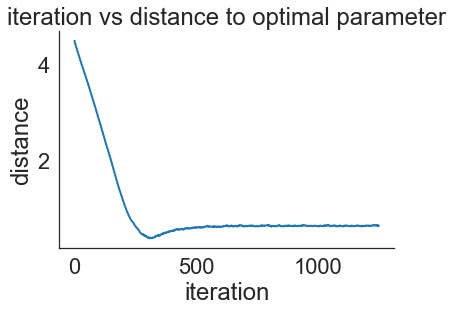

In [10]:
plot_dist_to_opt_param(klvi_param_history, klvi_var_param)

Due to the strong posterior correlation, the variational approximation dramatically underestimates uncertainty

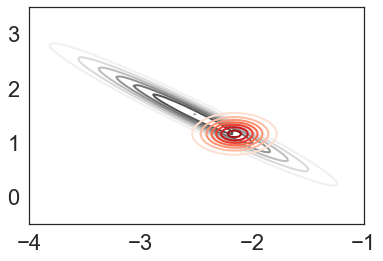

In [11]:
plot_approx_and_exact_contours(stan_log_density, mf_t_approx, klvi_var_param, **lims,
                               savepath='../figures/robust-regression-mf-klvi.pdf')

In [13]:
check_approx_accuracy(mf_t_approx, klvi_var_param, true_mean, true_cov, verbose=True);

mean   = [-2.15814684  1.16409895]
stdevs = [0.19148445 0.1942479 ]

mean error             = 0.494
stdev error            = 0.66
||cov error||_2^{1/2}  = 0.907
||true cov||_2^{1/2}   = 0.928


We can check approximation quality using `viabel`. All bounds suggest the approximation is not good:

In [15]:
_, log_weights = get_samples_and_log_weights(stan_log_density, mf_t_approx, klvi_var_param, mc_samples)
elbo = np.mean(log_weights)
var_dist_cov = mf_t_approx.mean_and_cov(klvi_var_param)[1]
moment_bound_fn = lambda p: mf_t_approx.pth_moment(klvi_var_param, p)

klvi_results = all_bounds(log_weights, q_var=var_dist_cov, moment_bound_fn=moment_bound_fn)

print_bounds(klvi_results)

Bounds on...
  2-Wasserstein   8.47
  2-divergence    10.2
  mean error      8.47
  stdev error     8.47
  sqrt cov error  12.1
  cov error       147


In [16]:
klvi_psis_results, _, _ = improve_with_psis(stan_log_density, mf_t_approx, klvi_var_param,
                                            mc_samples, true_mean, true_cov, verbose=True)

khat = 0.944

mean   = [-2.25076153  1.25196335]
stdevs = [0.37888025 0.3808679 ]

mean error             = 0.367
stdev error            = 0.396
||cov error||_2^{1/2}  = 0.763
||true cov||_2^{1/2}   = 0.928


/Users/jhuggins/Dropbox (Personal)/Research/repos/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


## Mean-field variational inference with CHIVI

We can repeat the same procedure, but this time using CHIVI and a Student t mean-field variational family. 

In [17]:
chivi_objective_and_grad = black_box_chivi(2, mf_t_approx, stan_log_density, 500)

init_var_param = klvi_var_param.copy()
init_var_param[2:] += 3

chivi_var_param, chivi_param_history, chivi_history, _ = \
    adagrad_optimize(n_iters, chivi_objective_and_grad, init_var_param, learning_rate=.01)

Average Loss = -18.839: 100%|██████████| 5000/5000 [01:37<00:00, 51.35it/s]


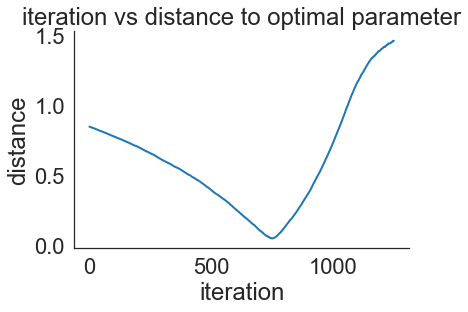

In [18]:
plot_dist_to_opt_param(chivi_param_history, chivi_var_param)

The variance is no longer so badly underestimated. But the variational approximation is still not very good, now greatly over-estimating the region with significant posterior mass:

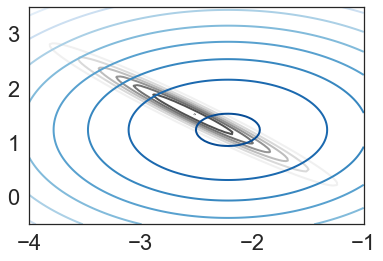

In [19]:
plot_approx_and_exact_contours(stan_log_density, mf_t_approx, chivi_var_param, **lims,
                               cmap2='Blues', savepath='../figures/robust-regression-mf-chivi.pdf')

In [20]:
check_approx_accuracy(mf_t_approx, chivi_var_param, true_mean, true_cov, verbose=True);

mean   = [-2.21747137  1.23755001]
stdevs = [2.09425309 2.17242768]

mean error             = 0.401
stdev error            = 2.08
||cov error||_2^{1/2}  = 2.14
||true cov||_2^{1/2}   = 0.928


The fact that approximation is still not good is reflected is the large bounds:

In [21]:
_, log_weights = get_samples_and_log_weights(stan_log_density, mf_t_approx, chivi_var_param, mc_samples)
var_dist_cov = mf_t_approx.mean_and_cov(chivi_var_param)[1]
moment_bound_fn = lambda p: mf_t_approx.pth_moment(chivi_var_param, p)

chivi_results = all_bounds(log_weights, q_var=var_dist_cov, log_norm_bound=elbo, moment_bound_fn=moment_bound_fn)

print_bounds(chivi_results)

Bounds on...
  2-Wasserstein   41.1
  2-divergence    6.94
  mean error      41.1
  stdev error     41.1
  sqrt cov error  59.6
  cov error       3.55e+03


In [22]:
chivi_psis_results, _, _ = improve_with_psis(stan_log_density, mf_t_approx, chivi_var_param,
                                             mc_samples, true_mean, true_cov, verbose=True)

khat = -0.952

mean   = [-2.52338934  1.51993351]
stdevs = [0.65510773 0.66516456]

mean error             = 0.0155
stdev error            = 0.0031
||cov error||_2^{1/2}  = 0.0569
||true cov||_2^{1/2}   = 0.928


/Users/jhuggins/Dropbox (Personal)/Research/repos/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


## A non-mean-field approximation

Finally, we obtain a very good approximation by using a Student t variational family with a full-rank scaling matrix. 

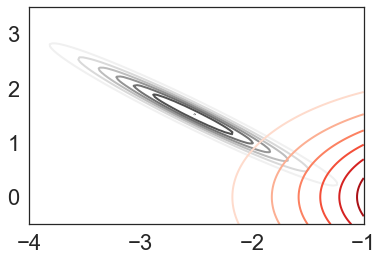

Average Loss = 22.66: 100%|██████████| 5000/5000 [00:33<00:00, 149.25it/s] 


In [23]:
t_approx = MultivariateT(2, 100)
full_klvi_objective_and_grad = black_box_klvi(t_approx, stan_log_density, 100)

init_var_param = np.zeros(t_approx.var_param_dim)
plot_approx_and_exact_contours(stan_log_density, t_approx, init_var_param, **lims)
full_klvi_var_param, full_klvi_param_history, full_klvi_history, _ = \
    adagrad_optimize(n_iters, full_klvi_objective_and_grad, init_var_param, 
                     learning_rate=.1, learning_rate_end=.001)

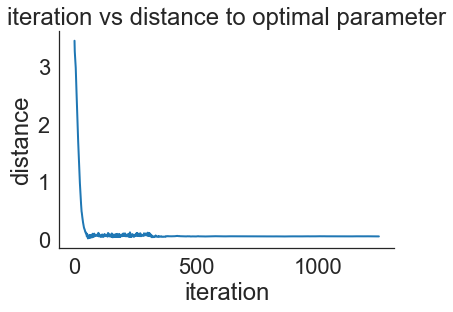

In [24]:
plot_dist_to_opt_param(full_klvi_param_history, full_klvi_var_param)

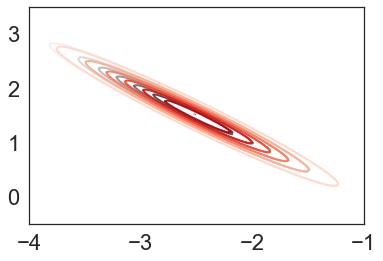

In [25]:
plot_approx_and_exact_contours(stan_log_density, t_approx, full_klvi_var_param, **lims,
                               savepath='../figures/robust-regression-full-rank-klvi.pdf')

In [26]:
check_approx_accuracy(t_approx, full_klvi_var_param, true_mean, true_cov, verbose=True);

mean   = [-2.4899156   1.48732269]
stdevs = [0.65547802 0.66511794]

mean error             = 0.0313
stdev error            = 0.00343
||cov error||_2^{1/2}  = 0.0609
||true cov||_2^{1/2}   = 0.928


Bounds computed using `viabel` -- and the 2-divergence bound in particular -- confirm that the approximation is accurate. 

In [27]:
_, log_weights = get_samples_and_log_weights(stan_log_density, t_approx, full_klvi_var_param, mc_samples)
var_dist_cov = t_approx.mean_and_cov(full_klvi_var_param)[1]
moment_bound_fn = lambda p: t_approx.pth_moment(full_klvi_var_param, p)

full_klvi_results = all_bounds(log_weights, q_var=var_dist_cov, moment_bound_fn=moment_bound_fn)

print_bounds(full_klvi_results)

Bounds on...
  2-Wasserstein   0.709
  2-divergence    0.00687
  mean error      0.155
  stdev error     0.709
  sqrt cov error  1.52
  cov error       2.32


In [28]:
full_klvi_psis_results, _, _ = improve_with_psis(stan_log_density, t_approx, full_klvi_var_param,
                                                 mc_samples, true_mean, true_cov, verbose=True)

khat = -0.96

mean   = [-2.52444171  1.52093701]
stdevs = [0.65516906 0.66589616]

mean error             = 0.0169
stdev error            = 0.00277
||cov error||_2^{1/2}  = 0.059
||true cov||_2^{1/2}   = 0.928


/Users/jhuggins/Dropbox (Personal)/Research/repos/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)
